In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from numpy.random import seed
from numpy.random import randn
import pandas as pd 
from sklearn.svm import OneClassSVM
from sklearn import metrics
from sklearn.metrics import accuracy_score

Librairies

In [7]:
#paramètres
nbapp=500
nbtest=10000
SigNoise=0.06 #écart-type du bruit additionnel
delta=0.1 #ecart entre les deux groupes
a=0.35 #position de la frontière entre les deux groupes (entre 0.3 et 0.4)


nbtirage=10*nbapp
g=np.random.uniform(0,1,(nbtirage,2))-0.5
mask1=abs(g)<a-delta/2
mask1=np.all(mask1, axis=1)
mask2=abs(g)>a+delta/2
mask2=np.any(mask2, axis=1)
data1=g[mask1,:]
data2=g[mask2,:]
Xapp=np.concatenate((data1[0:nbapp,:], data2[0:nbapp,:]), axis=0)
Xapp=Xapp+randn(2*nbapp,2)*SigNoise
un=np.ones(nbapp)
Lapp=np.concatenate((un, -un), axis=0)


nbtirage=10*nbtest
g=np.random.uniform(0,1,(nbtirage,2))-0.5
mask1=abs(g)<a-delta/2
mask1=np.all(mask1, axis=1)
mask2=abs(g)>a+delta/2
mask2=np.any(mask2, axis=1)
data1=g[mask1,:]
data2=g[mask2,:]
Xtest=np.concatenate((data1[0:nbtest,:], data2[0:nbtest,:]), axis=0)
Xtest=Xtest+randn(2*nbtest,2)*SigNoise
un=np.ones(nbtest)
Ltest=np.concatenate((un, -un), axis=0)

Data display

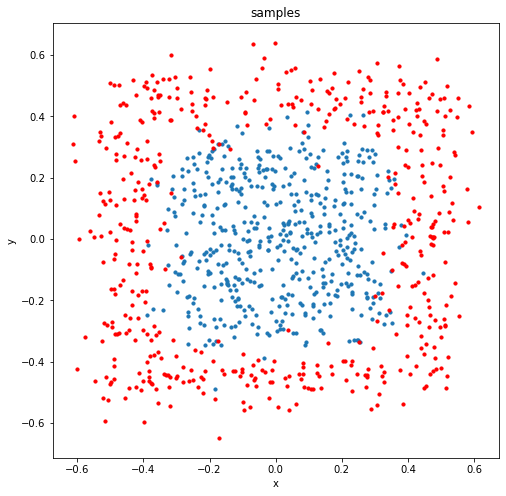

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(Xapp[0:nbapp-1,0],Xapp[0:nbapp-1:,1],s=10)
plt.scatter(Xapp[nbapp:2*nbapp-1,0],Xapp[nbapp:2*nbapp-1:,1],c='r',s=10)
plt.xlabel('x')  
plt.ylabel('y')  
  
# displaying the title 
plt.title("samples") 
plt.show()

Training 2 classes

[0.069, 0.07345]


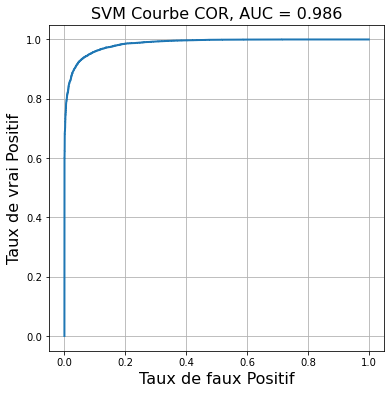

In [9]:
#paramètres:
kern='rbf'
gam=0.1
Cpen=10
deg=5


classifier = svm.SVC(kernel=kern,gamma=gam,C=Cpen)
classifier.fit(Xapp, Lapp)
y_app_pred = classifier.decision_function(Xapp)
lab_app_pred = np.sign(y_app_pred)
y_test_pred = classifier.decision_function(Xtest)
lab_test_pred = np.sign(y_test_pred)

eval_app=lab_app_pred-Lapp
eval_test=lab_test_pred-Ltest

print([sum(abs(eval_app))/nbapp/2/2,sum(abs(eval_test))/nbtest/2/2])

fpr, tpr, thr = metrics.roc_curve(Ltest,y_test_pred)

auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, '-', lw=2, label='Lineaire, AUC=%.2f' % auc)

plt.xlabel('Taux de faux Positif', fontsize=16)
plt.ylabel('Taux de vrai Positif', fontsize=16)
plt.title('SVM Courbe COR, AUC = %.3f'%auc, fontsize=16)
plt.grid()
plt.show()

One Class

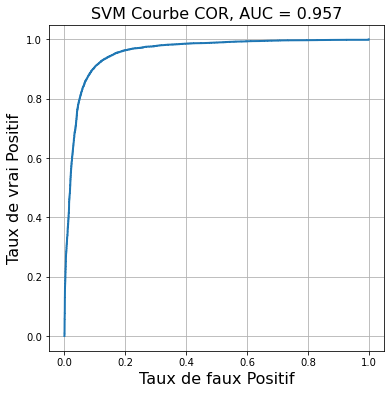

In [10]:
#paramètres:
kern='rbf'
gam=10
NU=0.05
deg=5

ocsvm = OneClassSVM(kernel=kern, gamma=gam,nu=NU)
ocsvm.fit(Xapp[nbapp:,:])
y_app_pred = ocsvm.score_samples(Xapp)
y_test_pred = ocsvm.score_samples(Xtest)

lab_app_pred = np.sign(y_app_pred)
lab_test_pred = np.sign(y_test_pred)
eval_app=lab_app_pred-Lapp
eval_test=lab_test_pred-Ltest

#print([sum(abs(eval_app))/nbapp/2/2,sum(abs(eval_test))/nbtest/2/2])

fpr, tpr, thr = metrics.roc_curve(-Ltest,y_test_pred)

auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, '-', lw=2, label='Lineaire, AUC=%.2f' % auc)

plt.xlabel('Taux de faux Positif', fontsize=16)
plt.ylabel('Taux de vrai Positif', fontsize=16)
plt.title('SVM Courbe COR, AUC = %.3f'%auc, fontsize=16)
plt.grid()
plt.show()

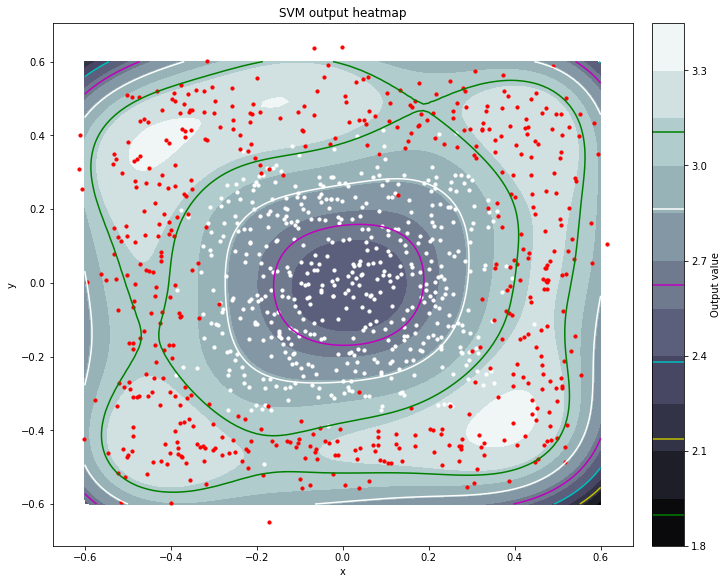

In [11]:
BX=0.6 
origin = 'lower'
nbs=100
delta=(2*BX)/(nbs-1)
x = y = np.arange(-BX, BX+0.0001, delta)
X, Y = np.meshgrid(x, y)
Xr=np.reshape(X,(nbs*nbs,1))
Yr=np.reshape(Y,(nbs*nbs,1))
Xmap=np.concatenate((Xr, Yr), axis=1)
Ymapr = ocsvm.score_samples(Xmap)
Ymap=np.reshape(Ymapr,(nbs,nbs))
MxYmap=np.max(Ymap)
MnYmap=np.min(Ymap)
lev_curves=np.linspace(MnYmap, MxYmap, num=7)
lev_curves=lev_curves[0:6]

fig1, ax1 = plt.subplots(constrained_layout=True,figsize=(10,8))
CS = ax1.contourf(X, Y, Ymap, 10, cmap=plt.cm.bone, origin=origin)
ax1.set_title('SVM output heatmap')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
CS2 = ax1.contour(CS, levels=lev_curves, colors=('g','y','c','m','w','g'), origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Output value')
cbar.add_lines(CS2)

ax1.scatter(Xapp[0:nbapp-1,0],Xapp[0:nbapp-1,1],c='w',s=10,alpha=1)
ax1.scatter(Xapp[nbapp:2*nbapp-1,0],Xapp[nbapp:2*nbapp-1,1],c='r',s=10,alpha=1)

plt.show()